# Fully Connected Neural Network with Cat-vs-NoCat and mnist data

This is a Fully Connected 5 layer Neural Network. 

With this network, two different classification problems were adressed: 

- Recognition of images "Cat-vs-NoCat", i.e. to classify whether an image contained a cat or not
- Hand-written digit recognition with the MNIST dataset

## Importing necessary libraries

Libraries used to define system path and to configure intitialization.

- config liabrary sets up seed, number of classes, epochs, learning rate, filename
- data_loader is a liabrary with following functions 
  - load_cvnc_data (to load cat vs. no cat data), returns train_set_x, train_set_y, test_set_x, test_set_y, classes (1/0)
  - load_mnist_data (to load mnist data), returns train_set_x, train_set_y, test_set_x, test_set_y, classes (one, two, three...)
  - normalize_image data (which normalizes the input images by dividing by 255)
  - one_hot_data (to flatten the output vector y)



In [1]:
import sys
sys.path.insert(0, f'src')
import config
import util
from data_loader import load_cvnc_data, load_minst_data, normalize_image_data, one_hot_data

## input images

Now we need to define a function to show the input image. 

show_image() takes the x, y set of examples, the class id list and an index as an input and then validates if the index is out of bounds of the input set. 

Image number, output y, class ('cat/non-cat'  in case of cvnc data and 'one/two/three..' in case of mnist data). the function may be called for both training and testing data split.

In [2]:
import matplotlib.pyplot as plt
def show_image(set_x, set_y, classes, index = 10):
    if index >= len(set_x): index = 0
    plt.imshow(set_x[index])
    print ("Image# " + str(index+1) +": y = " + str(set_y[0,index]) + ". It's a '" + classes[set_y[0,index]].decode("utf-8") +  "' picture.")


In [38]:
train_x_, train_y_, test_x_, test_y_, classes = load_cvnc_data()

Image# 11: y = 0. It's a 'non-cat' picture.


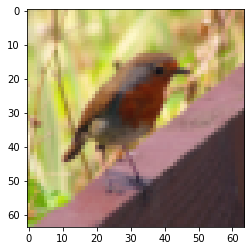

In [39]:
show_image(train_x_, train_y_, classes)

## Normalizing the input data

We update the train and test input features by normalizing the images. normalize_image_data() does that. 

Similarly the output vector is flatten by calling the function one_hot_data(). 

Both these functions have already been imported from data_loader library.

In [40]:
train_x = normalize_image_data(train_x_)
test_x  = normalize_image_data(test_x_)
train_y = one_hot_data(train_y_, classes)
test_y  = one_hot_data(test_y_, classes)

## Defining Fully Connected Layers

Next we import the class FullyConnectedLayer from file fc_layer. It takes number of inputs and outputs and the type of activation for one layer. The input, output and activation is sent as an argument to another class called FullyConnectedUnit. 

We then perform forward and backward propagation with the functions forward() and backward(). 

update() function updates Weights W and B with respect to learning rate (initially set as 0.01).

Now we define five hidden layers, four of which has Relu Activation and the last one has Softmax. Then number of inputs and outputs for the hidden layers are set manually.

In [6]:
from fc_layer import FullyConnectedLayer
fc0 = FullyConnectedLayer(train_x.shape[0],256,'Relu')
fc1 = FullyConnectedLayer(256,128,'Relu')
fc2 = FullyConnectedLayer(128,64,'Relu')
fc3 = FullyConnectedLayer(64,16,'Relu')
fcf = FullyConnectedLayer(16,len(classes),'Softmax')

## Setting up the Neural Network

Now we are all ready to set the Network. class NN_Network is imported from file nn_network. 

The only input is the starting *learning_rate*, which is halved by default every 500 epochs.

In [7]:
from nn_network import NN_Network
model = NN_Network(l_rate=0.02)

Add all layers to the neural network.

In [8]:
model.add_layer(fc0)
model.add_layer(fc1)
model.add_layer(fc2)
model.add_layer(fc3)
model.add_layer(fcf)

### Training the network (or loading from local cache)

Since training a neural network may take a while, it is useful to store the trained model as a python-object using Pickle.

This allows to share and reuse the model on different occasions, without having to re-train again.

In [9]:
train = False
if train:
    costs = model.train(train_x, train_y, 5000, dynamic_learning=True)
    util.dump_model(model)
else:
    model = util.load_model('cvnc')

### Analysis of the learning rate

It seems the network was able to quickly learn, and at epoch 1000 the cost didn't improve much.

Minimal cost achieved: 0.00073


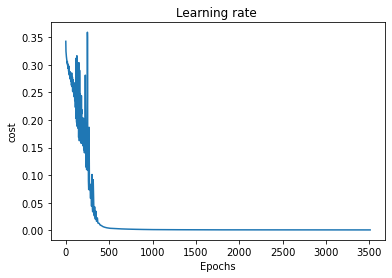

Cost at Epoch 500: 0.00382
Cost at Epoch 1000: 0.00131


In [10]:
import numpy as np
costs = np.squeeze(model.costs).round(5)
print(f"Minimal cost achieved: {costs.min()}")
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.title("Learning rate ")
plt.show()
print(f"Cost at Epoch 500: {costs[500]}")
print(f"Cost at Epoch 1000: {costs[1000]}")

### Model evaluation

The model has an accuracy of 76% on the test data and 100% on the train data.

In [46]:
predicted, actual = model.evaluate(test_x, test_y)
false_positives = [i for i, (p, a) in enumerate(zip(predicted[0], actual[0])) if p!=a and p==1]
false_negatives = [i for i, (p, a) in enumerate(zip(predicted[0], actual[0])) if p!=a and p==0]
print("Wrong predictions at indexes: ")
print(false_positives+false_negatives)

Accuracy: 0.760
Wrong predictions at indexes: 
[13, 29, 34, 44, 6, 18, 19, 26, 28, 40, 41, 46]


In [70]:
# accuracy on the train data
_ = model.evaluate(train_x, train_y)

Accuracy: 1.000


4 false positives: 


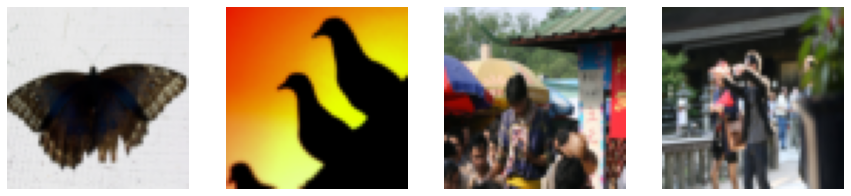

In [55]:
print(f"{len(false_positives)} false positives: ")
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
for i, p in enumerate(false_positives):
    ax[i].imshow(test_x_[p])
    ax[i].axis('off')

8 false negatives: 


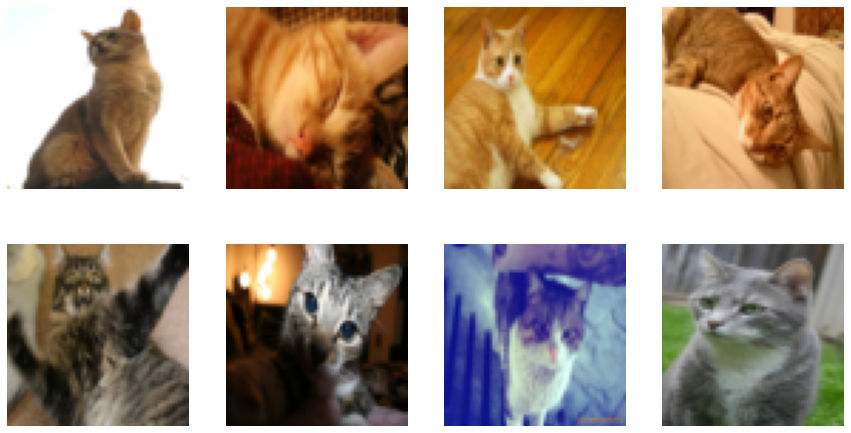

In [68]:
print(f"{len(false_negatives)} false negatives: ")
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
for i, p in enumerate(false_negatives):
    ax[int(i/4), i-4*int(i/4)].imshow(test_x_[p])
    ax[int(i/4), i-4*int(i/4)].axis('off')

# Applying to the MNIST Dataset

Next we move to a more challenging exercise, multi-class prediction with the MNIST dataset.

The goal is to accurately classify hand-written digits.

In [95]:
train_x_, train_y_, test_x_, test_y_, classes = load_minst_data()

Image# 46: y = 9. It's a 'Nine' picture.


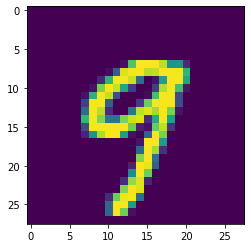

In [96]:
show_image(train_x_, train_y_, classes, index=45)

In [97]:
train_x = normalize_image_data(train_x_)
test_x  = normalize_image_data(test_x_)
train_y = one_hot_data(train_y_, classes)
test_y  = one_hot_data(test_y_, classes)

In [74]:
from fc_layer import FullyConnectedLayer
fc0 = FullyConnectedLayer(int(train_x.shape[0]   ),int(train_x.shape[0]/2 ),'Relu')
fc1 = FullyConnectedLayer(int(train_x.shape[0]/2 ),int(train_x.shape[0]/4 ),'Relu')
fc2 = FullyConnectedLayer(int(train_x.shape[0]/4 ),int(train_x.shape[0]/8 ),'Relu')
fc3 = FullyConnectedLayer(int(train_x.shape[0]/8 ),int(train_x.shape[0]/16),'Relu')
fcf = FullyConnectedLayer(int(train_x.shape[0]/16),len(classes),'Softmax')

In [75]:
from nn_network import NN_Network
model = NN_Network(l_rate=0.01)

In [76]:
model.add_layer(fc0)
model.add_layer(fc1)
model.add_layer(fc2)
model.add_layer(fc3)
model.add_layer(fcf)

In [134]:
train = True
if train:
    costs = model.train(train_x, train_y, 5000, dynamic_learning=True)
    util.dump_model(model, 'minst')
else:
    model = util.load_model('minst')

Training started
Learning rate = 0.01


KeyboardInterrupt: 

### Analysis of the learning rate

It seems the network was able to quickly learn, and at epoch 1000 the cost didn't improve much.

In [ ]:
import numpy as np
costs = np.squeeze(model.costs).round(5)
print(f"Minimal cost achieved: {costs.min()}")
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.title("Learning rate ")
plt.show()
print(f"Cost at Epoch 500: {costs[500]}")
print(f"Cost at Epoch 1000: {costs[1000]}")

### Model evaluation

The model has an accuracy of 81.8% on the test data and 81.6% on the train data.

In [ ]:
predicted, actual = model.evaluate(test_x, test_y)
false_positives = [i for i, (p, a) in enumerate(zip(predicted[0], actual[0])) if p!=a and p==1]
false_negatives = [i for i, (p, a) in enumerate(zip(predicted[0], actual[0])) if p!=a and p==0]
print("Total of wrong predictions: " + str(len(false_positives+false_negatives)))

In [88]:
# accuracy on the train data
_ = model.evaluate(train_x, train_y)

Accuracy: 0.816


138 false positives. Some examples: 


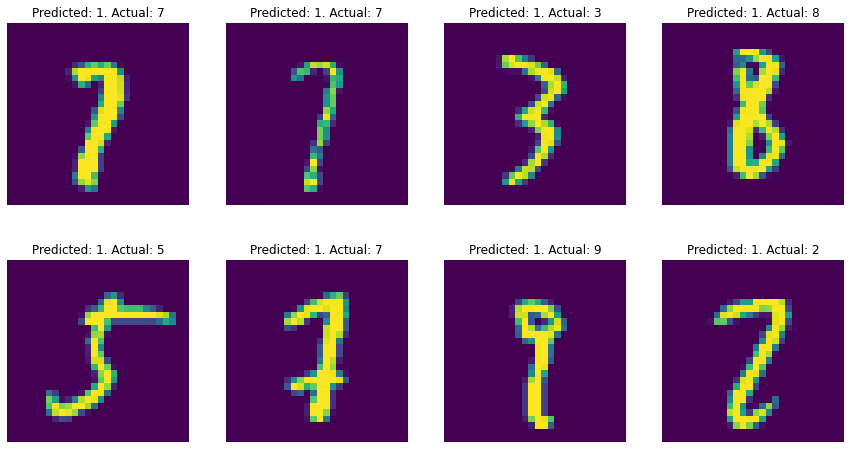

In [115]:
print(f"{len(false_positives)} false positives. Some examples: ")
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
for i, p in enumerate(false_positives):
    r = int(i/4)
    if i-4*r < ax.shape[1] and i < ax.shape[0]*ax.shape[1]:
        ax[r, i-4*r].imshow(test_x_[p])
        ax[r, i-4*r].axis('off')
        ax[r, i-4*r].set_title(f'Predicted: {predicted[0][p]}. Actual: {actual[0][p]}')

110 false negatives. Some examples: 


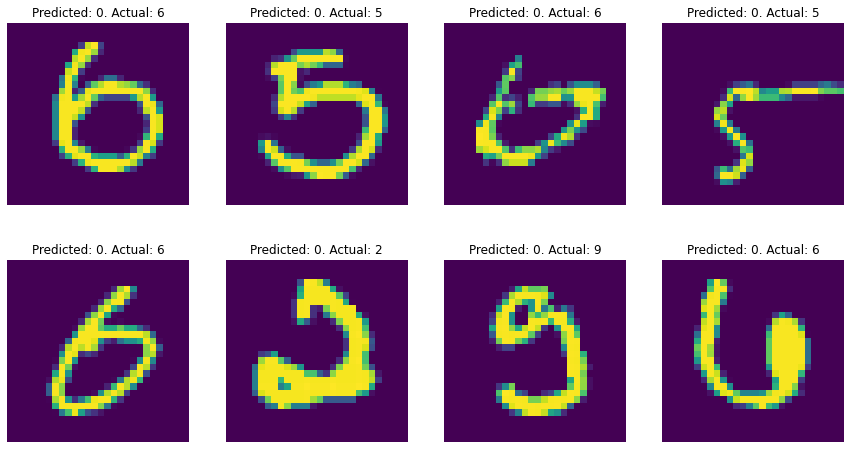

In [104]:
print(f"{len(false_negatives)} false negatives. Some examples: ")
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
for i, p in enumerate(false_negatives):
    r = int(i/4)
    if i-4*r < ax.shape[1] and i < ax.shape[0]*ax.shape[1]:
        ax[r, i-4*r].imshow(test_x_[p])
        ax[r, i-4*r].axis('off')
        ax[r, i-4*r].set_title(f'Predicted: {predicted[0][p]}. Actual: {actual[0][p]}')

### Comparison with scikit-learn's Multi-Layer Perceptron

To evaluate the quality of our model, we will compare it with sklearn's MLPClassifier. 

We tried to adjust the parameters to be as close as possible to those used before.

In [113]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(
    activation="relu", 
    hidden_layer_sizes=(int(train_x.shape[0]/2), int(train_x.shape[0]/4), int(train_x.shape[0]/8), int(train_x.shape[0]/16)),
    max_iter=600, 
    solver='sgd', # stochastic gradient descent
    learning_rate_init=0.01,
    learning_rate='invscaling',
    early_stopping=True
)
clf_mlp.fit(train_x.T, train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(392, 196, 98, 49),
              learning_rate='invscaling', learning_rate_init=0.01, max_iter=600,
              solver='sgd')

In [114]:
%%time
clf_mlp.score(test_x.T, test_y)

0.9057

Score is better than ours, but not as much! Fitting is however much faster.

When we compare both, it seems the MLP is also unable to correctly classify some of the tricky ones. 

It seems similar on the false negatives but rather different on the false positives (at least for these samples, which is rather anecdotal evidence).

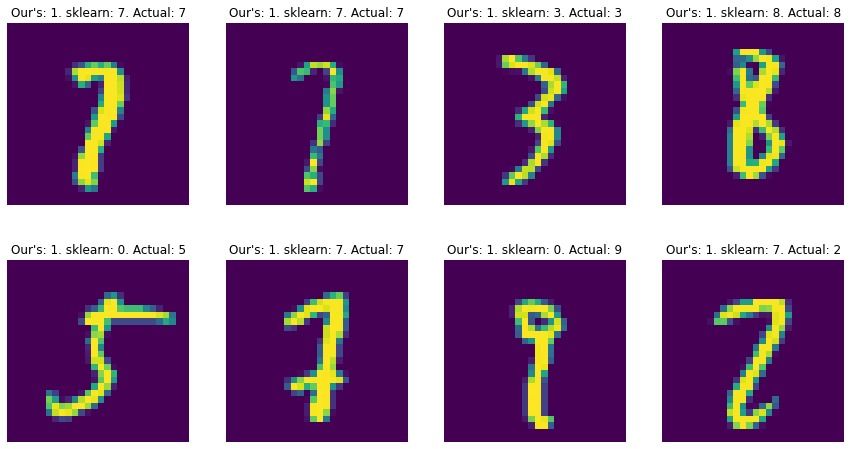

In [130]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
sklearn_predictions = clf_mlp.predict(test_x.T)
for i, p in enumerate(false_positives):
    r = int(i/4)
    if i-4*r < ax.shape[1] and i < ax.shape[0]*ax.shape[1]:
        ax[r, i-4*r].imshow(test_x_[p])
        ax[r, i-4*r].axis('off')
        ax[r, i-4*r].set_title(f"Our's: {predicted[0][p]}. sklearn: {sklearn_predictions[p].argmax()}. Actual: {actual[0][p]}")

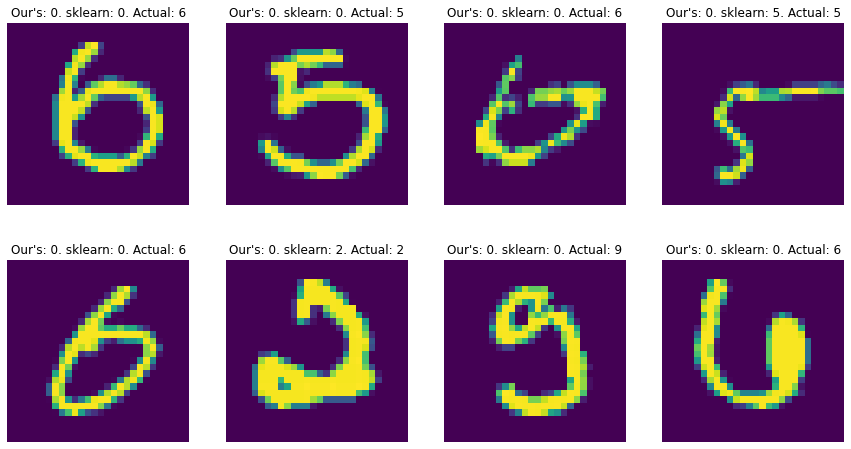

In [131]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
for i, p in enumerate(false_negatives):
    r = int(i/4)
    if i-4*r < ax.shape[1] and i < ax.shape[0]*ax.shape[1]:
        ax[r, i-4*r].imshow(test_x_[p])
        ax[r, i-4*r].axis('off')
        ax[r, i-4*r].set_title(f"Our's: {predicted[0][p]}. sklearn: {sklearn_predictions[p].argmax()}. Actual: {actual[0][p]}")